In [1]:
#Importing all libraries used 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import pandas as pd
import numpy as np
import timeit
import spacy
import re

### Data collection ✨

I found a wonderful "Fake News Prediction Dataset" on Kaggle. Its primary features are:
1. It consists of 6256 unique titles and 6060 unique texts
2. It has 4 columns: index, news title, news text and its label (Fake or Real)
3. Data is stored in "csv" format

Link is here: [Fake News Prediction Dataset](https://www.kaggle.com/datasets/rajatkumar30/fake-news/data )

In [2]:
# Download the dataset with utf-8 encoding, otherwise the data would be imported incorrectly 
df = pd.read_csv("news.csv", encoding="utf-8")
df

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,REAL
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,FAKE
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,FAKE
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",REAL


In [3]:
# Drop the useless column named "Unnamed: 0"
df = df.drop(columns=["Unnamed: 0"], axis=1)

### Data preparation ✨

Making predictive models is mainly about what data are used. Therefore, it is important to have a look at what we initially have and how to make it appropriate for further analysis. In this section, I have made the following:
1. Checked for NaNs and nulls. There are no such values;
2. Checked the column datatypes in DataFrame. I have only "str" data;
3. Checked the proportion between Fake and Real news. I am lucky, there is no need to handle the imbalanced dataset, because proportions are almost 50/50. In case of under/oversampling I would need to apply some approaches to equalize groups observations so that the algorithm would learn patterns correctly (let's imagine it had 1 Fake and 10 Real news, it would definitely learn to forecast only Real news);
4. Checked how the news titles and texts look like. It is a usual text with paragraphs, sentences, punctuation etc.
5. Clean the texts. Of course, measures should be taken to make data more "algorithm-friendly". Consequently, I cleaned texts with spaCy and its powerful tokenizer tool.

In [7]:
# Check for nulls and NaNs
df.any().isnull()

title    False
text     False
label    False
dtype: bool

In [8]:
# Check the column types
df.dtypes

title    object
text     object
label    object
dtype: object

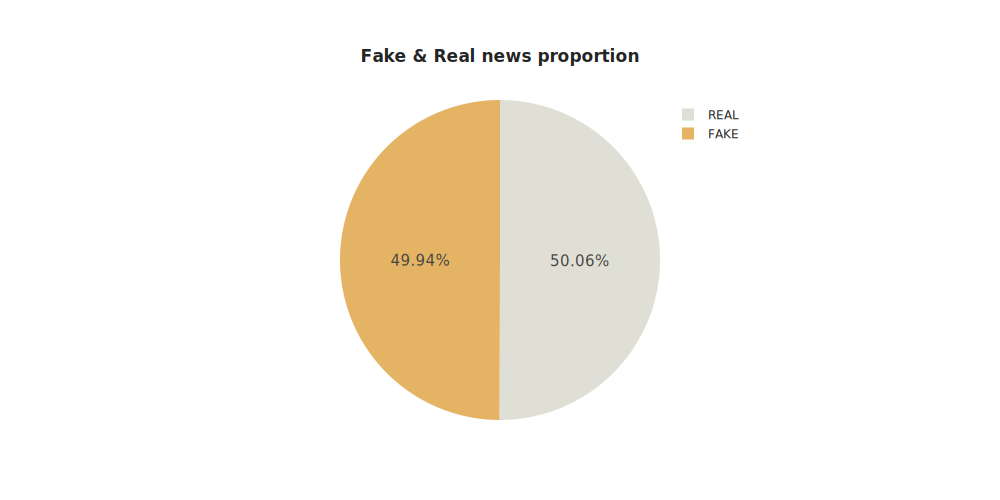

In [58]:
# Check the proportion of Fake and Real labels
labels = df["label"].unique()
fake_count = len(df[df["label"]=="FAKE"]["label"])
real_count = len(df[df["label"]=="REAL"]["label"])
values = [fake_count, real_count]
colors = ["#E4B363", "#E0DFD5"]

fig = go.Figure(data=[go.Pie(labels=labels, values=values)])
fig.update_layout(width=1000, height=500, 
                  legend=dict(y=1, x=0.7), 
                  title={'text': "<b>Fake & Real news proportion<b>",
                         'xanchor': 'center',
                         'x':0.5,
                         'yanchor': 'top'},)
fig.update_traces(marker=dict(colors=colors), 
                  texttemplate="%{percent:.2%}",
                  textfont_size=15)
fig.show("svg")

In [10]:
# Check how the news titles, texts and labels look like
df.iloc[0,1]
print('\033[1m'+"TITLE LOOKS LIKE:"+'\033[0m', df.iloc[0,0], "\n")
print('\033[1m'+"NEWS TEXT LOOKS LIKE:"+'\033[0m', df.iloc[0,1], "\n")
print('\033[1m'+"LABEL LOOKS LIKE:"+'\033[0m', df.iloc[0,2])

TITLE LOOKS LIKE: You Can Smell Hillary’s Fear 

NEWS TEXT LOOKS LIKE: Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. 
The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads agai

#### Clean texts

To make news titles and texts more suitable for objective assessment, I used the medium-sized NLP model from spaCy. Such a model choice is based on the following criteria:
1. This model is rather efficient (in fact, 95% as efficient as the large-sized NLP model)
2. This model weights much less than a large-sized one (40 MB vs 560 MB)
3. This model has text vectors which I will need for the model (small-sized does not have them)

Using spaCy allowed me to:
1. Turn DataFrame rows into docs with "nlp.pipe" function. When processing large volumes of text, this function is super efficient
2. Perform lemmatization process. Lemmatization is the process of reducing words to their base form, it improves the accuracy of NLP models
3. Remove stop words, punctuation and turn text to lowercase. Again, this should increase the accuracy of the model 

In [4]:
# Download spaCy English middle-sized model
nlp = spacy.load("en_core_web_md")

# Create the function for cleaning the text 
def clean_text(df_object):
    filtered_object = []
    for doc in nlp.pipe(df_object):
        temp = [token.lemma_ for token in doc if not token.is_stop]
        temp = " ".join(temp)
        temp = re.sub('[^A-Za-z0-9]+', ' ', temp)
        filtered_object.append(temp.lower())
    return filtered_object

In [5]:
filtered_title = clean_text(df["title"])
filtered_text = clean_text(df["text"])

In [6]:
df["filtered_title"] = filtered_title
df["filtered_text"] = filtered_text

In [14]:
fake_filtered_text = " ".join(df[df["label"] == "FAKE"]["filtered_text"].astype(str))
real_filtered_text = " ".join(df[df["label"] == "REAL"]["filtered_text"].astype(str))

In [15]:
fake_filtered_title = " ".join(df[df["label"] == "FAKE"]["filtered_title"].astype(str))
real_filtered_title = " ".join(df[df["label"] == "REAL"]["filtered_title"].astype(str))

#### Visualization. Part 1 🌄

After the preprocessing is done, let's have a look at what we have. First of all, it is interesting to check the most popular words in both Fake and Real titles and texts. Actually, it is complicated to make conclusions according to the Word Cloud. As observed, the most popular phrases in both groups are "Trump", "Clinton", "State". I assume it is better to make bar charts with most frequent words, this way the difference would be more obvious.

(-0.5, 6999.5, 4999.5, -0.5)

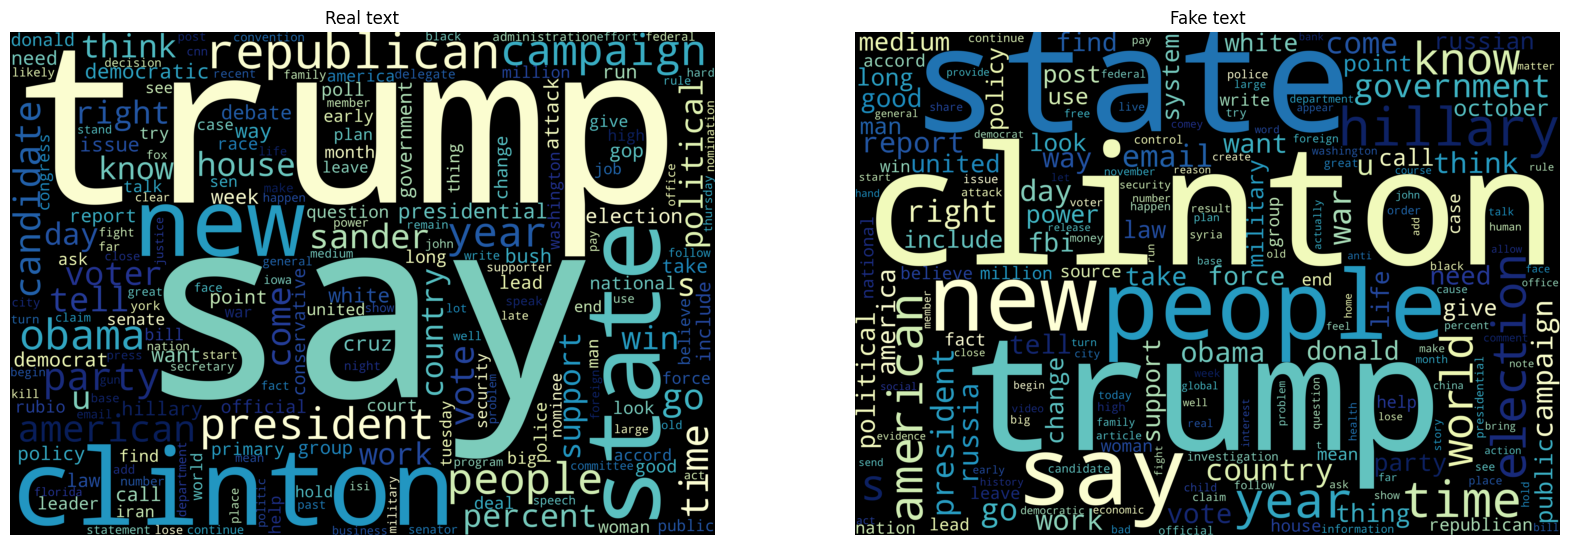

In [16]:
# WordCloud for Real news text
wc_r_te = WordCloud(width=7000, height=5000, collocations=False,
               background_color = 'black', random_state = 1, colormap="YlGnBu")
wc_r_te.generate(real_filtered_text)

# WordCloud for Fake news text
wc_f_te = WordCloud(width=7000, height=5000, collocations=False,
               background_color = 'black', random_state = 1, colormap="YlGnBu")
wc_f_te.generate(fake_filtered_text)

# Make a visualisation
fig = plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.imshow(wc_r_te, interpolation = 'bilinear')
plt.title('Real text')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wc_f_te, interpolation = 'bilinear')
plt.title('Fake text')
plt.axis('off')

(-0.5, 6999.5, 4999.5, -0.5)

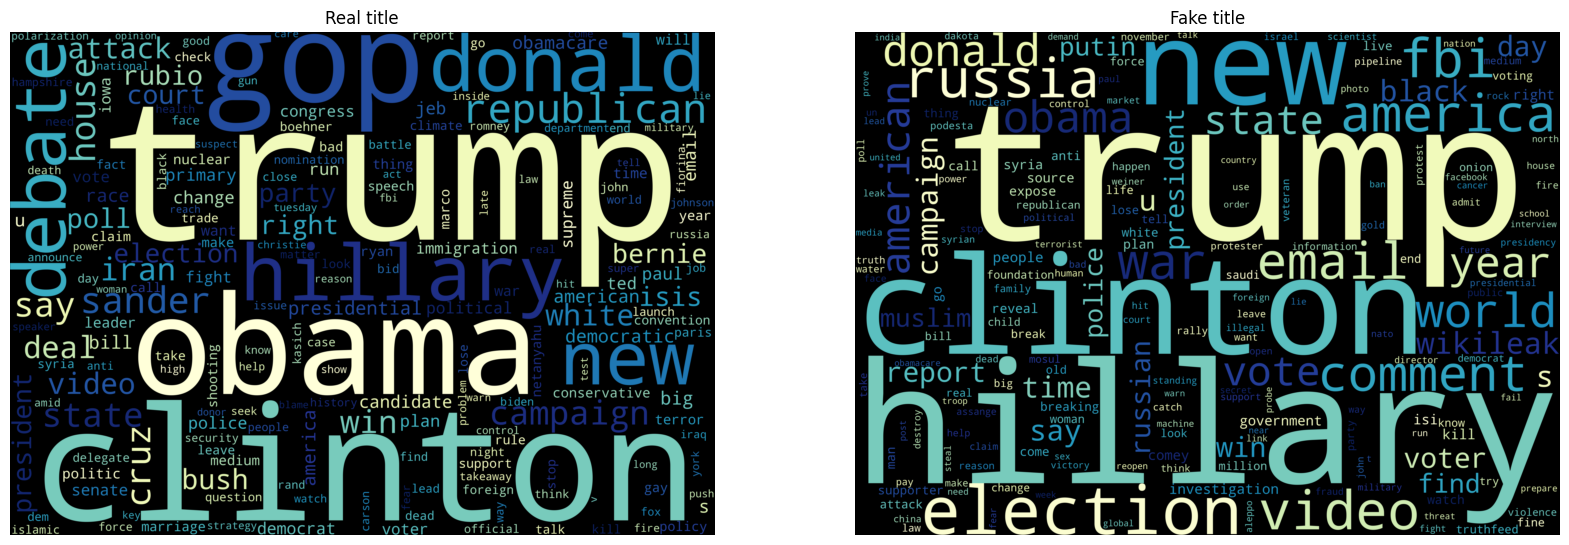

In [17]:
# WordCloud for Real titles
wc_r_ti = WordCloud(width=7000, height=5000, collocations=False,
               background_color = 'black', random_state = 1, colormap="YlGnBu")
wc_r_ti.generate(real_filtered_title)

# WordCloud for Fake titles
wc_f_ti = WordCloud(width=7000, height=5000, collocations=False,
               background_color = 'black', random_state = 1, colormap="YlGnBu")
wc_f_ti.generate(fake_filtered_title)

# Make a visualisation
fig = plt.figure(figsize = (20,10))
plt.subplot(1, 2, 1)
plt.imshow(wc_r_ti, interpolation = 'bilinear')
plt.title('Real title')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(wc_f_ti, interpolation = 'bilinear')
plt.title('Fake title')
plt.axis('off')

In [18]:
# Count the most frequent words for Real news text 
word_freq = Counter(real_filtered_text.split())
r_te_common_lemmas = word_freq.most_common(10)
r_te_common_lemmas

# Count the most frequent words for Fake news text 
word_freq = Counter(fake_filtered_text.split())
f_te_common_lemmas = word_freq.most_common(10)
f_te_common_lemmas

[('clinton', 6873),
 ('trump', 6764),
 ('people', 5538),
 ('say', 5488),
 ('hillary', 4601),
 ('state', 4147),
 ('year', 4097),
 ('time', 3618),
 ('election', 3613),
 ('new', 3547)]

In [19]:
# Count the most frequent words for Real news titles 
word_freq = Counter(real_filtered_title.split())
r_ti_common_lemmas = word_freq.most_common(10)
r_ti_common_lemmas

# Count the most frequent words for Real news titles 
word_freq = Counter(fake_filtered_title.split())
f_ti_common_lemmas = word_freq.most_common(10)
f_ti_common_lemmas

[('trump', 464),
 ('hillary', 404),
 ('clinton', 324),
 ('election', 193),
 ('new', 139),
 ('russia', 129),
 ('fbi', 125),
 ('video', 124),
 ('america', 116),
 ('comment', 109)]

#### Visualization. Part 2 🌄

**News titles**: the most used words are the same in both groups such as "Trump", "Clinton", "Hillary", "New" etc. Nevertheless, Fake titles are distinct with "Russia", "FBI" and "War" being mentioned too often. At the same time, Real news have "Obama" and "GOP" (the old name of the Republican Party) among the most popular phrases (Fakes do not have them in the top). 

**News texts**: news texts patterns have many similarities with titles. However, the most common word in Real texts is "say" being mentioned more than 20.000 times! It should be mentioned that "say" is a common word in Fake group too, but it has approximately 5.500 mentions. In addition, "President" and "Campaign" are also among the leaders in Real texts. These 2 words are not presented in the top 10 of Fake groups.

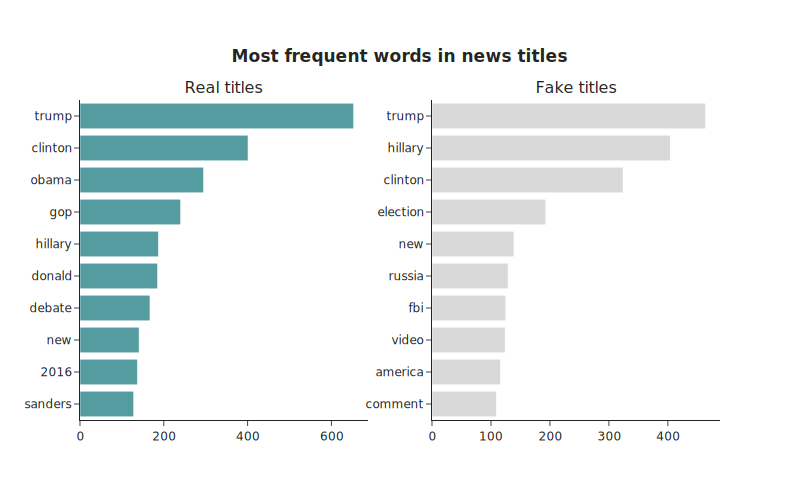

In [59]:
# Making a top-1o most frequent words visualisation in news titles
pio.templates.default = "simple_white"
fig = make_subplots(rows=1, cols=2, subplot_titles=("Real titles", "Fake titles"))

fig.add_trace(go.Bar(x=[int(tup[1]) for tup in r_ti_common_lemmas], 
                     y=[(tup[0]) for tup in r_ti_common_lemmas], 
                     orientation='h', marker_color='#549CA0'), row=1, col=1)

fig.add_trace(go.Bar(x=[int(tup[1]) for tup in f_ti_common_lemmas], 
                     y=[tup[0] for tup in f_ti_common_lemmas], 
                     orientation='h', marker_color='#d9d9d9'), row=1, col=2)

fig.update_layout(height=500, width=800, 
                  title={'text': "<b>Most frequent words in news titles<b>",
                         'xanchor': 'center',
                         'x':0.5,
                         'yanchor': 'top'},
                  yaxis=dict(autorange="reversed"),
                  yaxis2=dict(autorange="reversed"),
                  showlegend=False)
fig.show("svg")

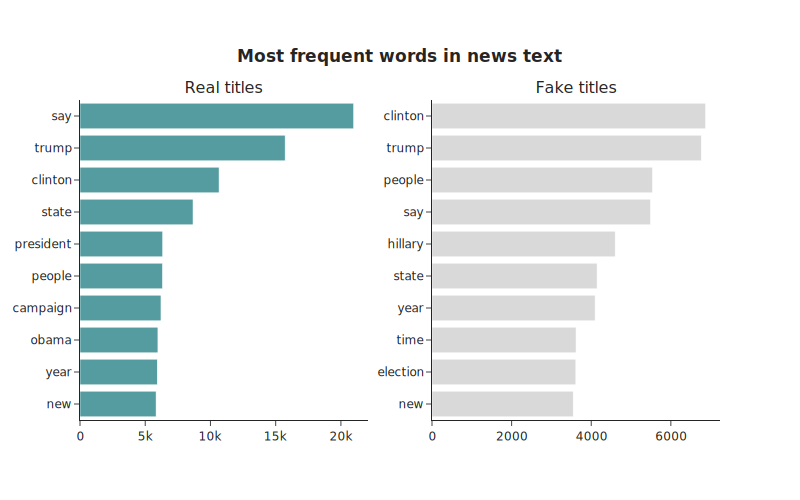

In [60]:
# Making a top-1o most frequent words visualisation in news text
pio.templates.default = "simple_white"
fig = make_subplots(rows=1, cols=2, subplot_titles=("Real titles", "Fake titles"))

fig.add_trace(go.Bar(x=[int(tup[1]) for tup in r_te_common_lemmas], 
                     y=[tup[0] for tup in r_te_common_lemmas], 
                     orientation='h', marker_color='#549CA0'), row=1, col=1)

fig.add_trace(go.Bar(x=[int(tup[1]) for tup in f_te_common_lemmas], 
                     y=[tup[0] for tup in f_te_common_lemmas], 
                     orientation='h', marker_color='#d9d9d9'), row=1, col=2)

fig.update_layout(height=500, width=800, 
                  title={'text': "<b>Most frequent words in news text<b>",
                         'xanchor': 'center',
                         'x':0.5,
                         'yanchor': 'top'},
                  yaxis=dict(autorange="reversed"),
                  yaxis2=dict(autorange="reversed"),
                  showlegend=False)

fig.show("svg")

### Feature engineering ✨

Now that we have cleaned text, it is necessary to prepare data for model training and validation. I did the following steps:
1. Encoded labels for Fake & Real*. Before designing the model, it is needed to transform text labels into binary labels (basically, "Fake & Real" into "0 & 1")
2. Vectorized the data. Vectorization is when we turn a text into a numerical form to make it possible to train and validate the model. Before I did this, I would like to know how to vectorize in the fastest way, so I have made 4 functions with different approaches and checked the time used to run these commands.
3. Make vectorized data appropriate for modeling. I have made a numpy array and then joined a sequence of arrays to make 1-D arrays
4. Splitted the data into training and testing samples. The proportion between training and testing sets are 80% and 20%, accordingly

***Remark**: CatBoost supports categorical features, but I wanted to make only-numeric dataset once and use it in all my attempt to train the algorithm, that is why I used sklearn LabelEncoder 

In [7]:
# Apply an Encoder to create (0, 1) out of (Fake, Real)
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["label"])
df.head()

,title,text,label,filtered_title,filtered_text
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0,smell hillary fear,daniel greenfield shillman journalism fellow f...
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0,watch exact moment paul ryan committed politic...,google pinterest digg linkedin reddit stumbleu...
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1,kerry paris gesture sympathy,u s secretary state john f kerry say monday st...
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0,bernie supporter twitter erupt anger dnc try w...,kaydee king kaydeeking november 9 2016 lesson...
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1,battle new york primary matter,primary day new york runner hillary clinton do...


In [8]:
# Create different vectorization functions 
def vectorize(df_object):
    temp = [row for row in df_object]
    docs = nlp.pipe(temp)
    return [doc.vector for doc in docs]

def vectorize_2(df_object):
    docs = nlp.pipe(df_object)
    return [doc.vector for doc in docs]

def vectorize_3(df_object):
    temp = [row for row in df_object]
    docs = nlp.pipe(df_object, n_process=4)
    return [doc.vector for doc in docs]

def vectorize_4(df_object):
    return df_object.apply(lambda x: nlp(x).vector)

In [24]:
# Check what is the fastest among these 4 functions
start = timeit.default_timer()
df["title_vector"] = vectorize(df["filtered_title"])
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  5.557806099997833


In [25]:
start = timeit.default_timer()
df["title_vector"] = vectorize_2(df["filtered_title"])
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  5.2962411000044085


In [26]:
start = timeit.default_timer()
df["title_vector"] = vectorize_3(df["filtered_title"])
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  27.416980499998317


In [27]:
start = timeit.default_timer()
df["title_vector"] = vectorize_4(df["filtered_title"])
stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  25.08314760000212


In [12]:
# Make separate columns with word vectors of titles and texts
df["title_vector"] = vectorize(df["filtered_title"])
df["text_vector"] = vectorize(df["filtered_text"])

In [14]:
# Split the data into training and testing
X = df["title_vector"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Dimension of training data: ', y_train.shape)
print('Dimension of test dat: ', y_test.shape)

Dimension of training data:  (5068,)
Dimension of test dat:  (1267,)


In [15]:
# Making 1-D arrays from modeling data
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = np.stack(X_train)
X_test = np.stack(X_test)

### Modeling ✨

CatBoost was chosen as a reliable technique for modeling. It is an open-source library with the gradient boosting on decision trees. Its primary advantages are:
1. Great quality without parameter tuning
2. Improved accuracy
3. Fast prediction

**How I used CatBoost:**
1. Fake or Real prediction based on news title and text
2. Applied default parameters and grid search*. My grid search opportunities were limited due to computer capabilities and the big size of the dataset 
3. CPU as a basis. My computer do not support the use of GPU for fast CatBoost modeling

**Remark:** Standard Scaler is not needed for Boosting algorithms, so it has not been used

In [10]:
from catboost import CatBoostClassifier

In [16]:
# Title-based models
# Import CatBoost library and train it
cat = CatBoostClassifier(silent=True)
cat.fit(X_train, y_train)

In [32]:
# Check the results
print("Training accuracy:", cat.score(X_train, y_train))
print("Testing accuracy:", cat.score(X_test, y_test))

Training accuracy: 0.9828334648776638
Testing accuracy: 0.760852407261247


**🚨 Model alert 🚨**

The default accuracy **(training is 22% more accurate than testing)** seems rather strange for CatBoost model taking into account its overfitting resistance. However, the problem may be in the data itself: it is possible that titles are just not appropriate for forecasting if news is Real or Fake. Another possible reason is the wrong usage of vectorizer, however, as it will be clear in the consequent text-based model, vectorizer works well.

To reduce the overfitting, I think it is time to play with hyperparameters a little bit (please remember: my computer is limited with possibilities). I am going to take only variations of the most important features:
1. **learning rate** - if you take the gradient step too big, it may get you a great accuracy loss; if too low - it would never come to the optimum. The default is 0.03, so let's take this value and a lower/bigger ones.
2. **depth** - how deep the trees of CatBoost will be. Usually it is in the range of 5 to 8, but I think we may try to get out of conventional borders
3. **L2 regularization** - how the fucntion would be penalized for wrong answers. If it is too big - the optimum would never be reached, otherwise the function would overfit. In my case I would try both extremes and a default number.

In [33]:
# Apply Grid Search to look for optimal hyperparameters
grid = {'learning_rate': [0.01, 0.03, 0.1],
        'depth': [3, 6, 9],
        'l2_leaf_reg':[1, 3, 5]}

cat2 = CatBoostClassifier(silent=True)
grid_search_result = cat2.grid_search(grid, X=X_train, y=y_train)


bestTest = 0.5559312146
bestIteration = 999

0:	loss: 0.5559312	best: 0.5559312 (0)	total: 6.76s	remaining: 2m 55s

bestTest = 0.5137632887
bestIteration = 999

1:	loss: 0.5137633	best: 0.5137633 (1)	total: 13.9s	remaining: 2m 54s

bestTest = 0.4899066918
bestIteration = 862

2:	loss: 0.4899067	best: 0.4899067 (2)	total: 22.2s	remaining: 2m 57s

bestTest = 0.5548511754
bestIteration = 999

3:	loss: 0.5548512	best: 0.4899067 (2)	total: 29.2s	remaining: 2m 47s

bestTest = 0.5069524114
bestIteration = 999

4:	loss: 0.5069524	best: 0.4899067 (2)	total: 36.1s	remaining: 2m 38s

bestTest = 0.5005233781
bestIteration = 595

5:	loss: 0.5005234	best: 0.4899067 (2)	total: 43.2s	remaining: 2m 31s

bestTest = 0.5541567915
bestIteration = 999

6:	loss: 0.5541568	best: 0.4899067 (2)	total: 50.9s	remaining: 2m 25s

bestTest = 0.5143083437
bestIteration = 999

7:	loss: 0.5143083	best: 0.4899067 (2)	total: 58.6s	remaining: 2m 19s

bestTest = 0.4818684098
bestIteration = 961

8:	loss: 0.4818684	best: 0

In [34]:
# Check the best hyperparameters from the Grid Search
grid_search_result["params"]

{'depth': 6, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

In [35]:
print("Training accuracy:", cat2.score(X_train, y_train))
print("Testing accuracy:", cat2.score(X_test, y_test))

Training accuracy: 0.9982241515390686
Testing accuracy: 0.760852407261247


**Title-based model results 📝**

After the Grid Search has been applied, the accuracy has not changed too much, and there is still an overfitting issue. In addition, taking into account an occurence of overfitting with default CatBoost features, I assume the title-based model is just not valide for accurate Fake/Real prediction in my case. Let's move on to the next model, the text-based one

In [13]:
# Text-based model
X = df["text_vector"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Dimension of training data: ', y_train.shape)
print('Dimension of test dat: ', y_test.shape)

Dimension of training data:  (5068,)
Dimension of test dat:  (1267,)


In [14]:
X_train = np.array(X_train)
X_test = np.array(X_test)
X_train = np.stack(X_train)
X_test = np.stack(X_test)

In [15]:
cat3 = CatBoostClassifier(silent=True)
cat3.fit(X_train, y_train)

**Text-based model? 📰**

High accuracy of text-based forecast proves the fact that the title-based approach is not valid in this project. Nevertheless, it should be admitted that there is still an overfitting issue as well **(training is 11% more accurate than testing)**, but it is not as severe as in the previous case. Let's apply the same features, but different values for Grid Search to make it a little bit more fun

In [35]:
print("Training accuracy:", cat3.score(X_train, y_train))
print("Testing accuracy:", cat3.score(X_test, y_test))

Training accuracy: 0.9966456195737964
Testing accuracy: 0.8855564325177585


In [40]:
grid = {'learning_rate': [0.01, 0.1, 0.2],
        'depth': [2, 3, 6],
        'l2_leaf_reg': [0.05, 2, 3]}

cat4 = CatBoostClassifier(silent=True)
grid_search_result = cat4.grid_search(grid, X=X_train, y=y_train)


bestTest = 0.4130404662
bestIteration = 999

0:	loss: 0.4130405	best: 0.4130405 (0)	total: 4.59s	remaining: 1m 59s

bestTest = 0.2804881992
bestIteration = 984

1:	loss: 0.2804882	best: 0.2804882 (1)	total: 9.04s	remaining: 1m 52s

bestTest = 0.2842120306
bestIteration = 912

2:	loss: 0.2842120	best: 0.2804882 (1)	total: 13.5s	remaining: 1m 48s

bestTest = 0.4132598902
bestIteration = 999

3:	loss: 0.4132599	best: 0.2804882 (1)	total: 18.2s	remaining: 1m 44s

bestTest = 0.2857881297
bestIteration = 981

4:	loss: 0.2857881	best: 0.2804882 (1)	total: 22.7s	remaining: 1m 40s

bestTest = 0.2762474367
bestIteration = 762

5:	loss: 0.2762474	best: 0.2762474 (5)	total: 27.3s	remaining: 1m 35s

bestTest = 0.413386562
bestIteration = 999

6:	loss: 0.4133866	best: 0.2762474 (5)	total: 31.8s	remaining: 1m 30s

bestTest = 0.2857486572
bestIteration = 998

7:	loss: 0.2857487	best: 0.2762474 (5)	total: 36.4s	remaining: 1m 26s

bestTest = 0.272671853
bestIteration = 809

8:	loss: 0.2726719	best: 0.2

In [41]:
grid_search_result["params"]

{'depth': 3, 'learning_rate': 0.2, 'l2_leaf_reg': 0.05}

In [42]:
print("Training accuracy:", cat4.score(X_train, y_train))
print("Testing accuracy:", cat4.score(X_test, y_test))

Training accuracy: 1.0
Testing accuracy: 0.8887134964483031


In [43]:
cat5 = CatBoostClassifier(silent=True, learning_rate=0.006)
cat5.fit(X_train, y_train)

In [44]:
print("Training accuracy:", cat5.score(X_train, y_train))
print("Testing accuracy:", cat5.score(X_test, y_test))

Training accuracy: 0.9183109707971586
Testing accuracy: 0.8524072612470402


### Model validation ✨

The best model was chosen to be default CatBoost (**cat3**) because of its R2 accuracy despite the difference between training and testing. The precise assessment was done with the help of "classification_report" and "confusion_matrix" functions. **The results of the best model are:**
1. F-1 score is 89%
2. 1122 out of 1267 observations from testing set were classified correctly

**What could be done better? 🚀**
1. There is no problem with text cleaning. It is done according to the conventional rules
2. There is no problem with model training. CatBoost is one of the most effective modern approaches providing high accuracy dy default
3. **There is a problem with vectorization**. In my draft I tried NLTK default vectorizer and it worked 4% better for testing. In real life I would definitely stick to that. However, I decided not to upload it in my notebook, because it is a spaCy project.  

In [16]:
# Make a classification report
predictions = cat3.predict(X_test)
target_names = ["Fake", "Real"]
report = classification_report(y_test, predictions, target_names=target_names)
print(report)

              precision    recall  f1-score   support

        Fake       0.89      0.88      0.88       628
        Real       0.88      0.90      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267



In [ ]:
# Make a confusion matrix of the best CatBoost model 
data = confusion_matrix(y_test, predictions, labels=[0,1])

fig = px.imshow(data, text_auto=True, 
                x=['Fake', 'Real'],
                y=['Fake', 'Real'],
                color_continuous_scale='Cividis')

fig.update_layout(width=1000, height=500, 
                  coloraxis_colorbar_x=0.8,
                  title={'text': "<b>Confusion matrix of the best CatBoost model<b>",
                         'xanchor': 'center',
                         'x':0.5, 'y':0.97,
                         'yanchor': 'top'},
                  xaxis = dict(
                        tickfont=dict(size=15)),
                  yaxis = dict(
                        tickfont=dict(size=15)),
                 )

fig.update_traces(textfont_size=15)

fig.show("svg")